In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import uuid #to generate random id
import pickle #to save/load list of selected hens

#test equal variance
from scipy.stats import levene

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score, r2_score,\
mean_squared_error, mean_absolute_error, explained_variance_score#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
from scipy.stats import pearsonr
import scipy.stats as stats


#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well


#plot
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp #for barplot
from mpl_toolkits.mplot3d import Axes3D

In [4]:
PACKAGE_PARENT = '../../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import chi2_distance, ts_visual, time_series_henColumn_tsRow, correct_key
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [5]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
#id_run = 'chapter0_final_'
#path_dataoutput = r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\DataOutput'
#path_extracted_data = os.path.join(path_dataoutput,'TrackingSystem') 
#path_extracted_data = os.path.join(path_extracted_data, id_run)
dico_night_hour = config.dico_night_hour
dico_matching = config.dico_matching
li_binmn = config.li_binmn
penalty = config.penalty
dico_window = config.dico_window
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
path_extracted_data_visual_adap_MVTCLUSTER = os.path.join(path_extracted_data_visual_adap,'MVTCLUSTERING')
path_extracted_data_visual_adap_MVTCLUSTER_tsvisual = os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'tsvisual')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_adap_MVTCLUSTER_tsvisual):
    os.makedirs(path_extracted_data_visual_adap_MVTCLUSTER_tsvisual)
print(id_run)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


change the configuration file if not done yet!
correctlightschedule_


In [6]:
rv = 0

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [7]:
#selected hens
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_visual_adap,'li_selected_hens.pkl'), 'rb'))
len(li_selected_hens)
#download the two groups
li_gr1 = list(pickle.load(open(os.path.join(path_extracted_data_visual_adap,'li_hen_NoMvt_3days.pkl'), 'rb')))
li_gr2 = list(pickle.load(open(os.path.join(path_extracted_data_visual_adap,'li_hen_Mvt_3days.pkl'), 'rb')))
dico_gr_name = {'group1':'NMVT' , 'group2':'MVT'}
print(len(li_gr1), len(li_gr2), len(li_gr1)+ len(li_gr2))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


47 84 131


In [8]:
#daily variables (one row per (henID, date))
df_daily = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed.csv'), sep=';',
                     parse_dates=['level','FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                              'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 
                              'Nestbox_time_of_first_staid_longer_than900sec',
                              'duration_last-firsttransition_mn'], dayfirst=True) 
df_daily['DOA'] = df_daily['level'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: int((x-119)/7)+1)
#df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: math.ceil(x/7))
#first two month seems good from the %of hens not moving plot! and sounds good too (twice longer thatn they need to start moving)
print(df_daily.shape)

#filter by dates
df_daily = df_daily[df_daily['level']<=max_date_adaptability] 
df_daily = df_daily[df_daily['level']>dt.datetime(2020,9,29)]

#filter the selected hens
df_daily = df_daily[df_daily['HenID'].isin(li_selected_hens)] 

df_daily['EarlyGroup'] = df_daily['HenID'].map(lambda x: dico_gr_name['group1'] if x in li_gr1 else np.nan)
df_daily['EarlyGroup'] = df_daily.apply(lambda x: dico_gr_name['group2'] if x['HenID'] in li_gr2 else x['EarlyGroup'], axis=1)

#remove days that are not fully recorded
df_daily['nbr_sec_per_day'] = df_daily['level'].map(lambda x: dico_night_hour[correct_key(x,dico_night_hour)]['nbr_hour']*60*60)
df_daily['is_correct_amount_time'] = df_daily.apply(lambda x: x['nbr_sec_per_day']==x['verification_daily_total_duration'], axis=1)
df_daily[(~df_daily['is_correct_amount_time'])&(~df_daily['Total_number_transition'].isnull())][['level', 'HenID', 'Total_number_transition', 'dur_values', 'verification_daily_total_duration','nbr_sec_per_day']]
print(df_daily.shape)
display(df_daily = df_daily[~((~df_daily['is_correct_amount_time'])&(~df_daily['Total_number_transition'].isnull()))])
print(df_daily.shape)

#remove the days where the night had movement recorded but not the days
print(df_daily.shape)
#display(df_daily[df_daily.isna().any(axis=1)])
df_daily = df_daily[~df_daily['verification_daily_total_duration'].isnull()]
print(df_daily.shape)
df_daily['DIB'] = df_daily['DOA'].map(lambda x: x-118)

df_daily['dur_values_normalized'].replace('[nan, nan, nan, nan, nan]','[np.nan,np.nan,np.nan,np.nan,np.nan]', inplace=True)
df_daily['dur_values_normalized'] = df_daily['dur_values_normalized'].map(lambda x: eval(x))
df_daily['duration_last-firsttransition_mn'] = df_daily['duration_last-firsttransition_mn'].astype(float)
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(42103, 218)
(6721, 219)
(6721, 219)
(6721, 219)
(6382, 219)
(6382, 220)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,PC2,PC3,PC4,PC5,PC6,PC7,clustering_ALL,weeks_in_laying_barn,EarlyGroup,DIB
0,hen_1,2020-09-30,0.0,18886.0,3488.0,515.0,5911.0,28800.0,"[0.0, 18886.0, 3488.0, 515.0, 5911.0]","[0.0, 0.6557638888888889, 0.12111111111111111,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MVT,1
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,"[0.0, 9310.0, 5636.0, 0.0, 17454.0]","[0.0, 0.2873456790123457, 0.17395061728395061,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MVT,2
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,"[0.0, 0.0, 551.0, 0.0, 31849.0]","[0.0, 0.0, 0.017006172839506173, 0.0, 0.982993...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MVT,3


In [9]:
#cleaned data of the tracking system movements
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', 
                 parse_dates=['Timestamp', 'date'], dayfirst=True) 
df = df[df['Timestamp']<=max_date_adaptability+dt.timedelta(days=2)] #add two days to have the next observations as well when doing the 1sec ts
df['hour'] = df['Timestamp'].map(lambda x: x.hour)
df['time'] = df['Timestamp'].map(lambda x: dt.datetime.time(x-dt.timedelta(seconds=x.second)))
df = df[df['HenID'].isin(li_selected_hens)] 
df.drop('duration', axis=1, inplace=True)
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(299628, 17)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
0,hen_71,pen12,10 - 12,3_Zone,1,2020-09-29 09:07:00,2020-09-29,2020-09-29 09:08:26.000,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:07:00
1,hen_7,pen11,10 - 12,3_Zone,1,2020-09-29 09:08:12,2020-09-29,2020-09-29 09:12:16.000,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:08:00
2,hen_10,pen11,10 - 12,3_Zone,1,2020-09-29 09:19:19,2020-09-29,2020-09-29 09:20:27.000,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:19:00


In [10]:
#focal birds info (one row per bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data,id_run+'df_FOCALBIRDS.csv'), sep=';', parse_dates=['InitialStartDate'],
                     dayfirst=True) 
df_FB = df_FB[df_FB['HenID'].isin(li_selected_hens)]
df_FB['EarlyGroup'] = df_FB['HenID'].map(lambda x: dico_gr_name['group1'] if x in li_gr1 else np.nan)
df_FB['EarlyGroup'] = df_FB.apply(lambda x: dico_gr_name['group2'] if x['HenID'] in li_gr2 else x['EarlyGroup'], axis=1)
df_FB['percentage_of_gain_weight'] = df_FB.apply(lambda x: (x['weight 23-11-2020']-x['29-09 weight'])/x['29-09 weight']*100, axis=1)
display(df_FB['EarlyGroup'].value_counts())
print(df_FB.shape)
df_FB.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MVT     84
NMVT    47
Name: EarlyGroup, dtype: int64

(131, 14)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,Treatment,EarlyGroup,percentage_of_gain_weight
0,hen_1,9,EPI,1.0,2020-06-10,1134.0,57.0,1696.5,1787.8,1800.9,NaN,OFH,MVT,49.603175
1,hen_10,11,LEXP,1.0,2020-06-10,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,OFH,NMVT,39.093458
3,hen_101,5,MEXP,3.0,2020-06-10,1082.0,66.0,1625.7,1751.1,1723.4,1762.5,OFH,MVT,50.249538


dico_gr_name = {'group1':'NMVT' , 'group2':'MVT'}
li_gr1 = li_selected_hens[0:60]
li_gr2 = li_selected_hens[60:]

# Basic plot about those two groups

In [11]:
#we dont normlaize it by pen or anything as we still wan tt se the true nbr of animals per pen/treatment/class
fig = dxp.count('PenID', data=df_FB, split='EarlyGroup')
fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerPen.png'))
fig = dxp.count('R-Pen', data=df_FB, split='EarlyGroup', split_order='desc') 
fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerRPen.png'))
fig = dxp.count('CLASS', data=df_FB, split='EarlyGroup') 
fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerClass.png'))
fig = dxp.count('Treatment', data=df_FB, split='EarlyGroup') 
fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerTreatment.png'))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


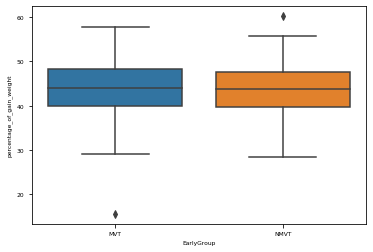

In [12]:
sns.boxplot(data=df_FB, x='EarlyGroup', y='percentage_of_gain_weight')
plt.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'percentage_of_gain_weight_pergroup.png'), bbox_inches='tight')
plt.show();

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,EarlyGroup,variable,value,date
163,hen_137,MVT,10-12 juin weight,65.5,2020-06-11
167,hen_140,MVT,10-12 juin weight,70.2,2020-06-11


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


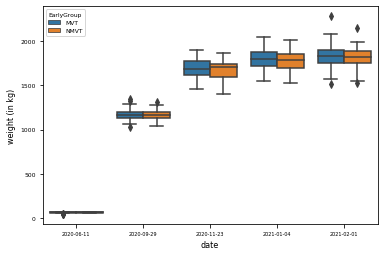

In [13]:
dico_name_date = {'29-09 weight':dt.date(2020,9,29),
                  '10-12 juin weight':dt.date(2020,6,11),
                  'weight 23-11-2020':dt.date(2020,11,23),
                  'weight 04-01-2021':dt.date(2021,1,4),
                  'weight 01-02-21':dt.date(2021,2,1)}
li_weight = list(dico_name_date.keys())
df_weight = pd.melt(df_FB, id_vars=['HenID','EarlyGroup'], value_vars=li_weight)
df_weight['date'] = df_weight['variable'].map(lambda x: dico_name_date[x])
df_weight.sort_values(['date'], inplace=True)
display(df_weight.head(2))
ax = sns.boxplot(data=df_weight, x='date', y='value', hue='EarlyGroup')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 5)
#ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 5)
plt.ylabel('weight (in kg)',fontsize=8);
plt.xlabel('date',fontsize=8);
plt.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'Weight.png'), bbox_inches='tight')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(279581, 4)


,DOA,HenID,variable,duration_of_stay
0,150,hen_1,1_Zone,190
1,150,hen_1,1_Zone,379
2,151,hen_1,1_Zone,61


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 104.22it/s]

(15, 6)


,time_range,Winter garden,Litter,Lower perch,Nestbox,Top floor
0,0h -1h,13666,79584,97870,51032,24660
1,1h -2h,80,2938,514,729,4054
2,2h -3h,4,297,27,39,1614


,Winter garden,Litter,Lower perch,Nestbox,Top floor
time_range,,,,,
0h -1h,5.121959,29.827744,36.681259,19.126576,9.242463
1h -2h,0.962117,35.333734,6.181600,8.767288,48.755262
2h -3h,0.201918,14.992428,1.362948,1.968703,81.474003


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


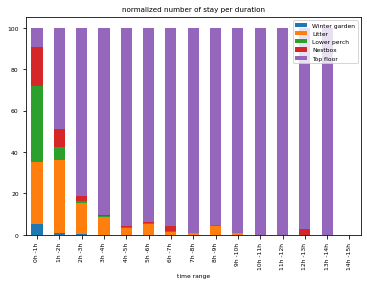

In [14]:
df_dur = df_daily[['dico_zone_sortedduration','HenID','DOA']].copy()
df_dur = df_dur[~df_dur['dico_zone_sortedduration'].isnull()]
df_dur['dico_zone_sortedduration'] = df_dur['dico_zone_sortedduration'].map(lambda x: eval(x))
df_dur = pd.concat([df_dur.drop(['dico_zone_sortedduration'], axis=1), df_dur['dico_zone_sortedduration'].apply(pd.Series)], 
                   axis=1)
df_dur = pd.melt(df_dur, id_vars=['HenID', 'DOA'], value_vars=['1_Zone', '2_Zone', '3_Zone', '4_Zone', '5_Zone'])
#remove all the stay that are=np.nan i.e.e not existing in this zone o that day by that hen
df_dur = df_dur[~df_dur['value'].isnull()]
df_dur = df_dur.set_index(['DOA','HenID','variable']).value.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(int).reset_index()
df_dur.rename(columns={0:'duration_of_stay'}, inplace=True)
#TODO: add weight and then plot!
print(df_dur.shape)
display(df_dur.head(3))
li_df = []
for h in tqdm.tqdm(range(0,15)):
    df_ = df_dur[(df_dur['duration_of_stay']>=(h*60*60))&(df_dur['duration_of_stay']<((h+1)*60*60))].copy()
    dico_ = {'time_range':str(h)+'h -'+str(h+1)+'h', 
             'Winter garden': df_[df_['variable']=='1_Zone'].shape[0], 
             'Litter': df_[df_['variable']=='2_Zone'].shape[0], 
             'Lower perch': df_[df_['variable']=='3_Zone'].shape[0], 
             'Nestbox': df_[df_['variable']=='4_Zone'].shape[0], 
             'Top floor': df_[df_['variable']=='5_Zone'].shape[0]}
    li_df.append(dico_)
df_plt = pd.DataFrame(li_df)
print(df_plt.shape)
display(df_plt.head(3))
df_plt = df_plt.set_index('time_range')
df_plt.fillna(0,inplace=True)
df_plot_normalized = df_plt.div(df_plt.sum(axis=1)/100, axis=0)
display(df_plot_normalized.head(3))
df_plot_normalized.plot(kind='bar',stacked=True);
plt.xlabel('time range')
plt.title('normalized number of stay per duration')
plt.savefig(os.path.join(path_extracted_data_visual_adap,'Duration_of_stays_perZone.png'), bbox_inches='tight')
plt.show();

# Difference in movement patterns?

In [15]:
df_daily['EarlyGroup'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MVT     4100
NMVT    2282
Name: EarlyGroup, dtype: int64

In [16]:
display(list(df_daily.columns))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['HenID',
 'level',
 'duration_1_Zone',
 'duration_2_Zone',
 'duration_3_Zone',
 'duration_4_Zone',
 'duration_5_Zone',
 'verification_daily_total_duration',
 'dur_values',
 'dur_values_normalized',
 'FirstTimestamp_1_Zone',
 'FirstTimestamp_2_Zone',
 'FirstTimestamp_3_Zone',
 'FirstTimestamp_4_Zone',
 'FirstTimestamp_5_Zone',
 'Total_number_zone',
 'list_of_durations',
 'list_of_zones',
 'Max_duration_zones',
 'dico_zone_sortedduration',
 'Total_number_transition',
 'distribution_entropy',
 'vertical_travel_distance',
 't_DU_missingZone_mvtPerc',
 'li_event_chaoticmvt_z_d',
 'nbr_stays_3_Zone',
 'nbr_appearances_3_Zone',
 'empproba_3_Zone',
 'nbr_stays_4_Zone',
 'nbr_appearances_4_Zone',
 'empproba_4_Zone',
 'nbr_stays_5_Zone',
 'nbr_appearances_5_Zone',
 'empproba_5_Zone',
 'nbr_stays_2_Zone',
 'nbr_appearances_2_Zone',
 'empproba_2_Zone',
 'nbr_stays_1_Zone',
 'nbr_appearances_1_Zone',
 'empproba_1_Zone',
 'Max_duration_zone_4',
 'down_missingZone_mvtPerc',
 'up_missingZone_mvtPerc'

In [17]:
li_times_var = ['FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone','FirstTimestamp_4_Zone', 
                'FirstTimestamp_5_Zone', 'Nestbox_time_of_first_staid_longer_than900sec']
dico_v_name = {'FirstTimestamp_1_Zone':'minutes until light turn off after first moment in WG', 
               'FirstTimestamp_2_Zone':'minutes until light turn off after first moment in litter', 
               'FirstTimestamp_3_Zone':'minutes until light turn off after first moment in lowerperch',
               'FirstTimestamp_4_Zone':'minutes until light turn off after first moment in nestboxzone', 
               'FirstTimestamp_5_Zone':'minutes until light turn off after first moment in top floor', 
               'Nestbox_time_of_first_staid_longer_than900sec':'minutes until light turn off after first transition longer than 15mn to nestboxzone'}
for v in li_times_var:
    df_daily[dico_v_name[v]] = df_daily[v].map(lambda x: (dt.datetime(x.year,x.month,x.day,dico_night_hour[correct_key(x, dico_night_hour)]['end_h'],
             dico_night_hour[correct_key(x, dico_night_hour)]['end_m'],0)-x).total_seconds()/60 if x is not pd.NaT else 0)
    
#small verifications
#df_daily[['Nestbox_time_of_first_staid_longer_than900sec','minutes until light turn off after first transition longer than 15mn to nestboxzone']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


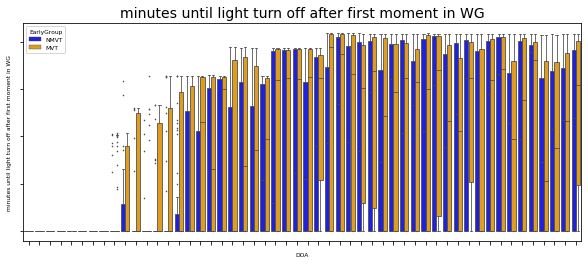

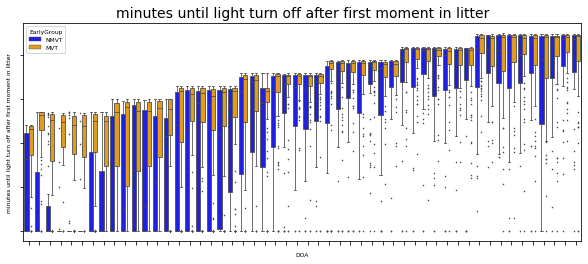

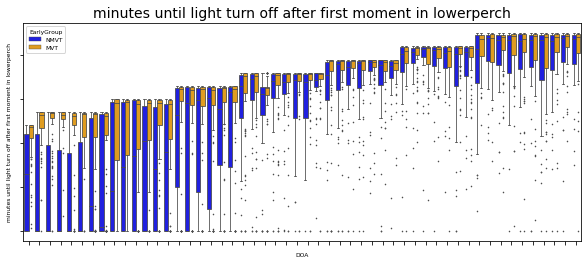

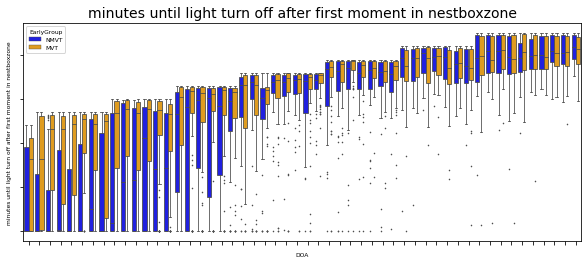

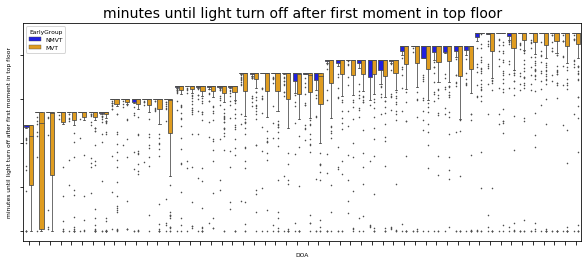

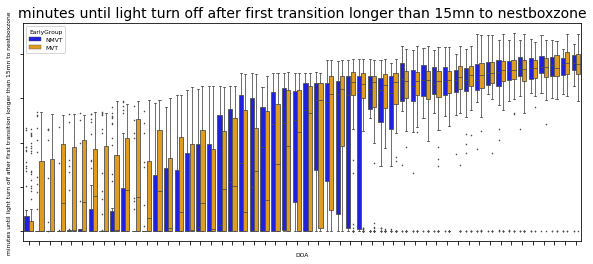

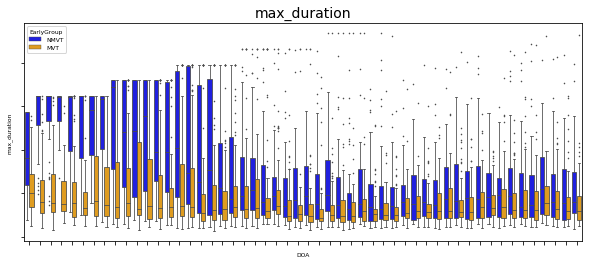

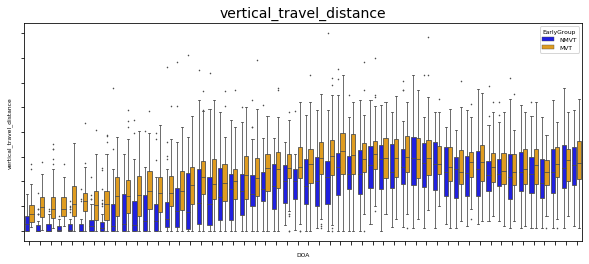

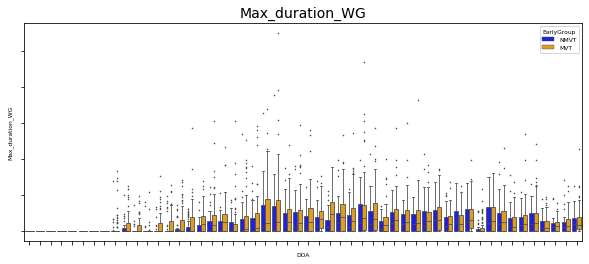

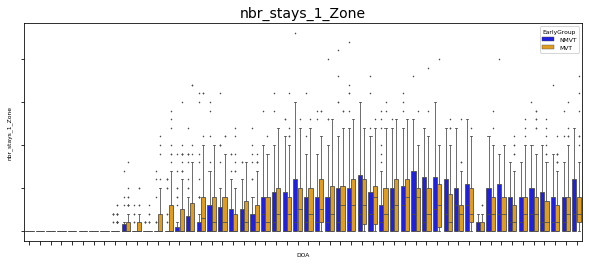

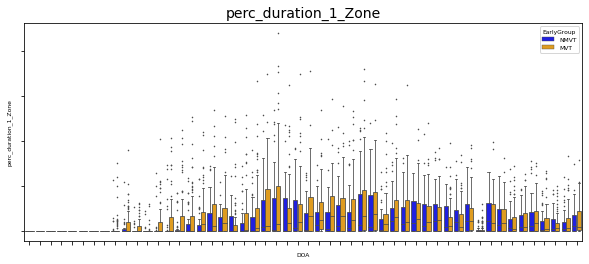

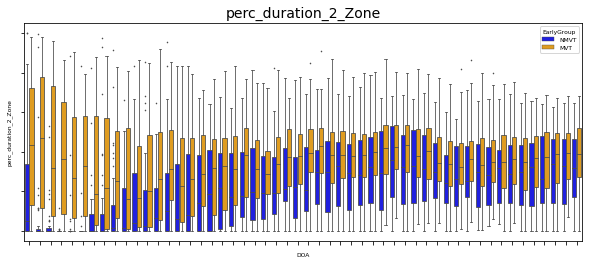

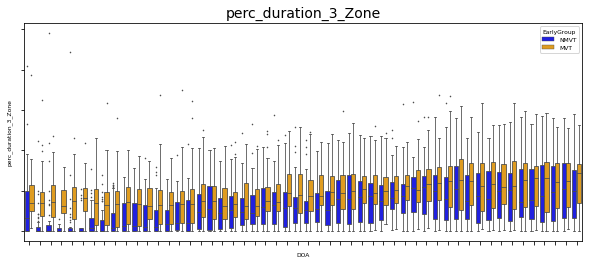

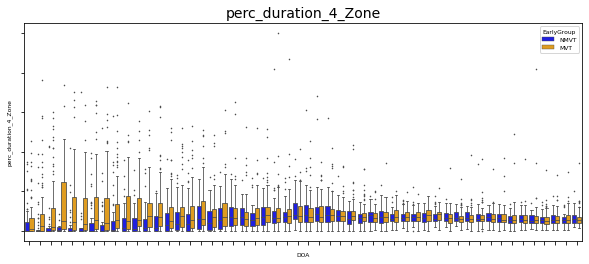

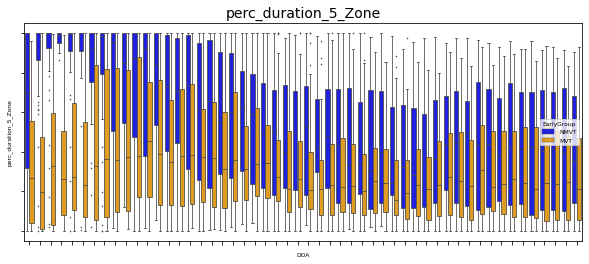

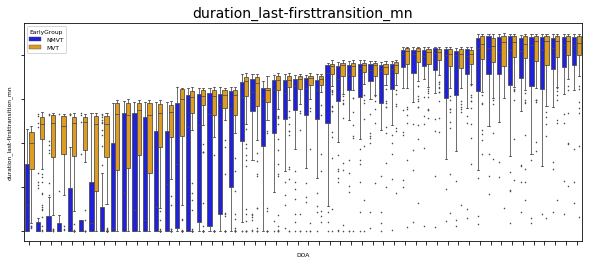

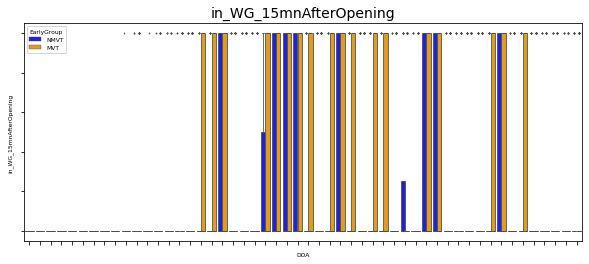

In [21]:
li_activity = list(dico_v_name.values())+['max_duration','vertical_travel_distance', 'Max_duration_WG','nbr_stays_1_Zone',
               'perc_duration_1_Zone', 'perc_duration_2_Zone', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 
               'perc_duration_5_Zone', 'duration_last-firsttransition_mn','in_WG_15mnAfterOpening']
for v in li_activity:
    fig = plt.subplots(figsize=(10,4)) 
    ax = sns.boxplot(x="DOA", y=v, hue="EarlyGroup", data=df_daily, linewidth=0.8, fliersize=0.7, 
                palette = {'NMVT':'blue', 'MVT':'orange'}, hue_order=['NMVT','MVT']);
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title(v, fontsize=14)
    plt.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,v+'.png'), bbox_inches='tight', dpi=300)
    plt.show();

In [23]:
path_extracted_data_visual_adap_MVTCLUSTER

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'G:\\VPHI\\Welfare\\2- Research Projects\\OFHE2.OriginsE2\\DataOutput\\TrackingSystem\\correctlightschedule_\\visual\\Treatment&Classs\\adaptability\\MVTCLUSTERING'

In [22]:
#save for stats
display(df_daily[df_daily['level']==dt.datetime(2020,10,10)][['DOA','DIB']].head(2))
df_daily[li_activity+['HenID','PenID','DIB','EarlyGroup']].to_csv(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER, 
                                                                    'df_daily_variables.csv'), sep=';', index=False)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,DOA,DIB
8,129,11
223,129,11


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-10-14,down_missingZone_mvtPerc,0.0
1,MVT,hen_1,2020-10-15,down_missingZone_mvtPerc,0.0
2,MVT,hen_1,2020-10-16,down_missingZone_mvtPerc,0.0


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


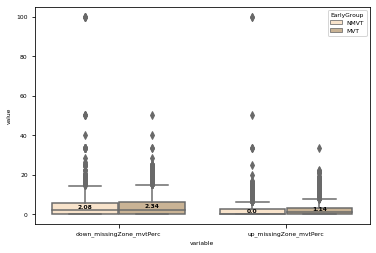

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-10-14,max_duration,36000.0
1,MVT,hen_1,2020-10-15,max_duration,36000.0
2,MVT,hen_1,2020-10-16,max_duration,39600.0


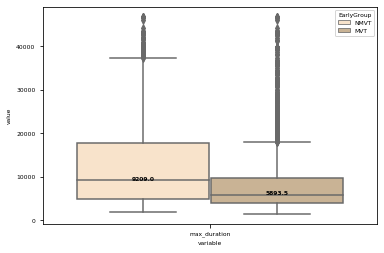

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-10-14,vertical_travel_distance,0.0
1,MVT,hen_1,2020-10-15,vertical_travel_distance,0.0
2,MVT,hen_1,2020-10-16,vertical_travel_distance,0.0


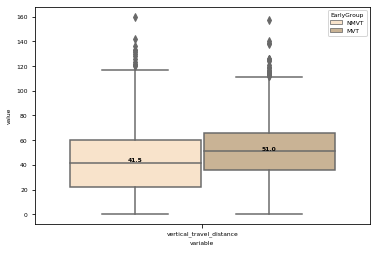

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-10-14,in_WG_15mnAfterOpening,0.0
1,MVT,hen_1,2020-10-15,in_WG_15mnAfterOpening,0.0
2,MVT,hen_1,2020-10-16,in_WG_15mnAfterOpening,0.0


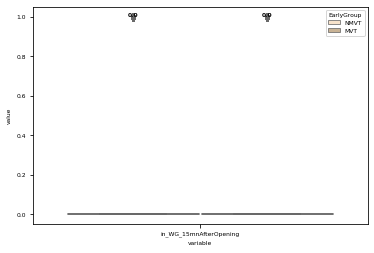

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-10-14,Max_duration_WG,0.0
1,MVT,hen_1,2020-10-15,Max_duration_WG,0.0
2,MVT,hen_1,2020-10-16,Max_duration_WG,0.0


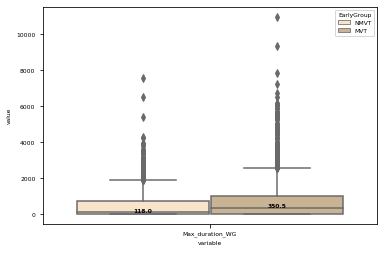

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-10-14,nbr_stays_1_Zone,0.0
1,MVT,hen_1,2020-10-15,nbr_stays_1_Zone,0.0
2,MVT,hen_1,2020-10-16,nbr_stays_1_Zone,0.0


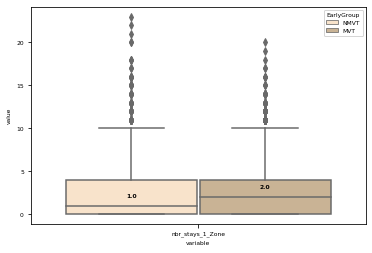

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-10-14,perc_duration_1_Zone,0.0
1,MVT,hen_1,2020-10-15,perc_duration_1_Zone,0.0
2,MVT,hen_1,2020-10-16,perc_duration_1_Zone,0.0


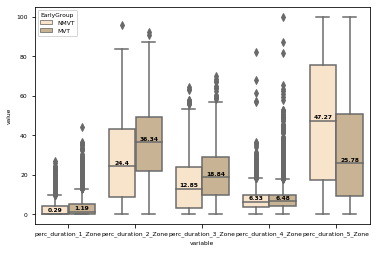

In [18]:
#### QUANTITATIF: plot boxplot for each x variable in each cluster (given by the 'cluster_name' column from df)
li_activity = [['down_missingZone_mvtPerc', 'up_missingZone_mvtPerc'], 'max_duration','vertical_travel_distance',
               'in_WG_15mnAfterOpening', 'Max_duration_WG','nbr_stays_1_Zone',
              ['perc_duration_1_Zone', 'perc_duration_2_Zone', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 
               'perc_duration_5_Zone']]
name_ = 1
for x in li_activity:
    df_plt = pd.melt(df_daily[df_daily['level']>=dt.datetime(2020,10,14)], id_vars=['EarlyGroup','HenID','level'], value_vars=x).reset_index(drop=True)
    display(df_plt.head(3))
    name_ = name_+1
    
    testPlot = sns.boxplot(x='variable', y='value', hue='EarlyGroup', data=df_plt, 
                           palette = {'NMVT':'bisque', 'MVT':'tan'}, hue_order=['NMVT','MVT'])
    m1 = df_plt.groupby(['variable', 'EarlyGroup'])['value'].median().values
    mL1 = [str(np.round(s, 2)) for s in m1]

    ind = 0
    for tick in range(len(testPlot.get_xticklabels())):
        testPlot.text(tick-.2, m1[ind+1]+1, mL1[ind+1],  horizontalalignment='center',  color='black', weight='semibold')
        testPlot.text(tick+.2, m1[ind]+1, mL1[ind], horizontalalignment='center', color='black', weight='semibold')
        ind += 2        
    
    plt.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,str(name_)+'.png'), bbox_inches='tight', dpi=300)
    plt.show();

OLD#### QUANTITATIF: plot boxplot for each x variable in each cluster (given by the 'cluster_name' column from df)
li_activity = [['down_missingZone_mvtPerc', 'up_missingZone_mvtPerc'], 'max_duration','vertical_travel_distance',
               'in_WG_15mnAfterOpening', 'Max_duration_WG','nbr_stays_1_Zone',
              ['perc_duration_1_Zone', 'perc_duration_2_Zone', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 
               'perc_duration_5_Zone']]
name_ = 1
for x in li_activity:
    df_plt = pd.melt(df_daily[df_daily['level']>=dt.datetime(2020,10,14)], id_vars=['EarlyGroup','HenID','level'], value_vars=x).reset_index(drop=True)
    display(df_plt.head(3))
    ax = sns.boxplot(x="variable", y="value", hue="EarlyGroup",data=df_plt, palette="Set3")
    name_ = name_+1
    plt.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,str(name_)+'.png'), bbox_inches='tight')
    plt.show();

# Compute differences

In [19]:
#intersection of two list
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 
lst1 = [15, 9, 10, 56, 23, 78, 5, 4, 9] 
lst2 = [9, 4, 5, 36, 47, 26, 10, 45, 87] 
print(intersection(lst1, lst2)) 

[9, 10, 4, 5]


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
#for efficiency purpose let's compute the bined time series first
#note that we will have more entries than needed, as the distrubances days are not removed in the raw-cleaned movements
#dataframe.
dico_bin_zone_level_h = {}   
dmin = dt.datetime(2020,9,30)
dmax = dt.datetime(2020,11,22)

print('computing time series...')
df_ts = time_series_henColumn_tsRow(df[(df['date']<=dmax)&(df['HenID'].isin(li_gr1+li_gr2))], 
                                    config, col_ts='Zone', ts_with_all_hen_value=False, save=False,  hen_time_series=False)
df_ts = df_ts[df_ts['date']>=dmin] #after the time series computation!! otherwise empty rows at the begining of the first day!

print('Extract binary ts of MLP...')
for nbr_binmn in tqdm.tqdm(li_binmn):
    
    #update results
    dico_bin_zone_level_h[nbr_binmn] = {}

    #reduce to the interval we want
    mi = min(df_ts['Timestamp'].tolist())
    ma = max(df_ts['Timestamp'].tolist())
    #extend the end to the end of the day in case it case the last day available fo the chicken
    Daterange = pd.date_range(start = mi, end = ma, freq = str(nbr_binmn)+'MIN')    
    df_date = pd.DataFrame({str(nbr_binmn)+'mn_timestamp':Daterange})
    new_timestamp = str(nbr_binmn)+'mn_timestamp'
    df_date[new_timestamp] = df_date[new_timestamp].map(lambda x: pd.to_datetime(x))
    df_ts_ = pd.merge_asof(df_ts, df_date, left_on=['Timestamp'], right_on=[new_timestamp], direction='forward')
    #groupby the interval that we want with the number of minutes in nestbox
    li_hen = [v for v in df_ts.columns if 'hen_' in v]
    for ZONE in df['Zone'].unique():

        #update results
        dico_bin_zone_level_h[nbr_binmn][ZONE] = {}

        df_zone_sim = df_ts_.groupby(new_timestamp)[li_hen].agg(lambda x: sum([i==ZONE for i in x])/60).reset_index()
        df_zone_sim['date'] = df_zone_sim[new_timestamp].map(lambda x: dt.datetime(x.year,x.month,x.day))

        #groupby date to have a list of zones per day (rows) for the hens (columns)
        df_zone_sim = df_zone_sim.groupby('date')[li_hen].agg(lambda x: list(x)).reset_index()
        #print(df_zone_sim.shape)
        #display(df_zone_sim.head(3))

        #melt to have one row per (day, hens) to avoid looping to create the dictionary
        df_zone_sim_ = pd.melt(df_zone_sim, id_vars=['date'], value_vars=li_hen)
        #variable column has the henIDs
        #print(df_zone_sim_.shape)
        #display(df_zone_sim_.head(3))
        for d, df__ in df_zone_sim_.groupby(['date']):
            #update results
            dico_bin_zone_level_h[nbr_binmn][ZONE][d] = dict(zip(df__['variable'].tolist(), df__['value'].tolist()))
#save dictionary
pickle.dump(dico_bin_zone_level_h, open(os.path.join(path_extracted_data_visual_adap, 
                                                 id_run+'dico_bin_zone_level_h_SAMEDAYS_MVTNOMVT.pkl'), 'wb'), pickle.HIGHEST_PROTOCOL)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing time series...
in this time series there is 132 hens
The initial starting date in over all is: 2020-09-29 09:07:00, and the ending date will be: 2020-11-22 22:44:55
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-29 09:07:00, and the ending date will be: 2020-11-22 23:59:59
Total running time: 1.34 mn


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Extract binary ts of MLP...


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [49:49<00:00, 597.87s/it]


In [21]:
#compute the chi2-distance from any two normalized vector of durations per zone that are from consectives days and same pen
random.seed(rv)
li_df = []
li_zone = df['Zone'].unique()
df.sort_values(['Timestamp'], inplace=True)
li_date = set(df_daily['level'].tolist())
df_doa = df_daily[['level','DOA','WOA']].drop_duplicates()
df_doa.head(3)
for d1 in tqdm.tqdm(sorted(list(li_date))):
    doa = df_doa[df_doa['level']==d1]['DOA'].values[0]
    woa = df_doa[df_doa['level']==d1]['WOA'].values[0]
    li_hen_d1 = df_daily[df_daily['level']==d1]['HenID'].unique()
    #its a symmetric measure, so we only do each combination once
    for i,h1 in enumerate(li_hen_d1):

        #for each hen we want to compute its difference with a random bird from the same group AND with a random bird from the
        #other group
        
        #first extract list of available hens that day from each group
        li_gr1_d = intersection(li_hen_d1, li_gr1)
        li_gr2_d = intersection(li_hen_d1, li_gr2)
        
        #remove the actual hen (h1)
        if h1 in li_gr1_d:
            li_gr1_d.remove(h1)
            gr1 = 'group1'
        if h1 in li_gr2_d:
            li_gr2_d.remove(h1)
            gr1 = 'group2'
        
        #then choose one hen from each group
        if ((len(li_gr1_d)!=0) & (len(li_gr2_d)!=0)):
            h2_gr1 = random.sample(li_gr1_d, 1)[0]
            h2_gr2 = random.sample(li_gr2_d, 1)[0]
        
            #finally compute the difference
            for h2,gr2 in zip([h2_gr1, h2_gr2],['group1','group2']):

                ############ Overall aviary usage similarity across days
                l1_chi2 = df_daily[(df_daily['HenID']==h1)&(df_daily['level']==d1)]['dur_values_normalized'].values[0]
                l2_chi2 = df_daily[(df_daily['HenID']==h2)&(df_daily['level']==d1)]['dur_values_normalized'].values[0]

                dico_ = {'level':d1, 'level+1':d1, 'henID1':h1, 'henID2':h2, 
                         'dur_values_normalized_henID1':l1_chi2,'dur_values_normalized_henID2':l2_chi2,'grouph1':gr1,'grouph2':gr2,
                         'chi2distance':chi2_distance(l1_chi2,l2_chi2),'DOA':doa,'WOA':woa}

                ############# Specifics' zones usage similarity across days
                for nbr_binmn in li_binmn:
                    for ZONE in li_zone:
                        dtw_value = np.nan
                        try:
                            l1_dtw = np.array(dico_bin_zone_level_h[nbr_binmn][ZONE][d1][h1], dtype=np.double)
                            l2_dtw = np.array(dico_bin_zone_level_h[nbr_binmn][ZONE][d1][h2], dtype=np.double)
                            #compute distance measure
                            #psi: #of start and end points of a sequence can be ignored if this would lead to a lower distance
                            dtw_value, paths = dtw.warping_paths(l1_dtw, l2_dtw, window=dico_window[nbr_binmn], psi=0, penalty=penalty) #, max_step=0
                        except Exception as e:
                            print(e)
                            sys.exit()
                            pass #dont do anything
                        dico_['DTW_'+str(nbr_binmn)+'_'+ZONE] = round(dtw_value,1)  
                        dico_['nbr_obs_l1_'+str(nbr_binmn)+'_'+ZONE] = len(l1_dtw)
                        dico_['nbr_obs_l2_'+str(nbr_binmn)+'_'+ZONE] = len(l2_dtw)
                li_df.append(dico_)
        else:
            print('WARNING: ', len(li_gr1_d), ' ', len(li_gr2_d), ' ', d1)

#turn inter and intra distances into a dataframe                
df_interintra = pd.DataFrame(li_df)
#df_interintra = df_interintra[~df_interintra['chi2distance'].isnull()]
df_interintra['is_same_group'] = df_interintra.apply(lambda x: x['grouph1']==x['grouph2'], axis=1)
df_interintra['Group'] = df_interintra.apply(lambda x: dico_gr_name[x['grouph1']] if x['grouph1']==x['grouph2'] else '', axis=1)
df_interintra = df_interintra.sort_values('DOA', ascending=True)
dico_name = {True: 'Intra group', False:'Inter group'}
df_interintra['type'] = df_interintra.apply(lambda x: (dico_name[x['is_same_group']]+' - '+x['Group']).strip(' - '), axis=1)
display(df_interintra['type'].value_counts())
df_interintra['weeks_in_laying_barn'] = df_interintra['DOA'].map(lambda x: int((x-119)/7)+1)
df_interintra['DTW_15_all'] = df_interintra[['DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone']].sum(axis=1)
df_interintra.to_csv(os.path.join(path_extracted_data_visual_adap ,id_run+str(rv)+'_df_interintra_SAMEDAY.csv'), sep=';', index=False)
print(df_interintra.shape)
display(df_interintra.head(3))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [24:21<00:00, 28.11s/it]


Inter group           6429
Intra group - MVT     4100
Intra group - NMVT    2329
Name: type, dtype: int64

(12858, 91)


,level,level+1,henID1,henID2,dur_values_normalized_henID1,dur_values_normalized_henID2,grouph1,grouph2,chi2distance,DOA,...,nbr_obs_l1_30_4_Zone,nbr_obs_l2_30_4_Zone,DTW_30_1_Zone,nbr_obs_l1_30_1_Zone,nbr_obs_l2_30_1_Zone,is_same_group,Group,type,weeks_in_laying_barn,DTW_15_all
0,2020-09-30,2020-09-30,hen_1,hen_26,"[0.0, 0.6557638888888889, 0.12111111111111111,...","[0.0, 0.0, 0.0, 0.0, 1.0]",group2,group1,0.659560,119,...,48,48,0.0,48,48,False,,Inter group,1,292.1
166,2020-09-30,2020-09-30,hen_53,hen_44,"[0.0, 0.2619097222222222, 0.16125, 0.003715277...","[0.0, 0.2826388888888889, 0.24145833333333333,...",group1,group1,0.041252,119,...,48,48,0.0,48,48,True,NMVT,Intra group - NMVT,1,250.8
167,2020-09-30,2020-09-30,hen_53,hen_42,"[0.0, 0.2619097222222222, 0.16125, 0.003715277...","[0.0, 0.0446875, 0.014583333333333334, 0.32642...",group1,group2,0.296556,119,...,48,48,0.0,48,48,False,,Inter group,1,276.4


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([5.518e+03, 2.034e+03, 2.200e+03, 1.662e+03, 8.220e+02, 3.980e+02,
        1.450e+02, 5.300e+01, 2.200e+01, 4.000e+00]),
 array([ 0.  ,  6.69, 13.38, 20.07, 26.76, 33.45, 40.14, 46.83, 53.52,
        60.21, 66.9 ]),
 <BarContainer object of 10 artists>)

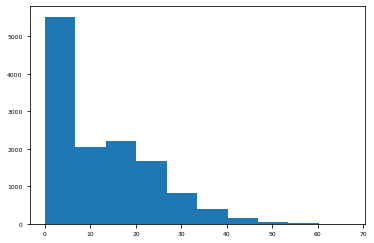

In [22]:
plt.hist(df_interintra['DTW_15_1_Zone'])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([3756., 2762., 1755., 1240.,  944.,  724.,  584.,  398.,  330.,
         365.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

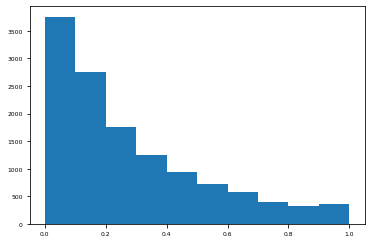

In [23]:
plt.hist(df_interintra['chi2distance'])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([ 301.,  347.,  944., 1494., 1581., 2073., 2169., 2019., 1342.,
         588.]),
 array([  0. ,  14.7,  29.4,  44.1,  58.8,  73.5,  88.2, 102.9, 117.6,
        132.3, 147. ]),
 <BarContainer object of 10 artists>)

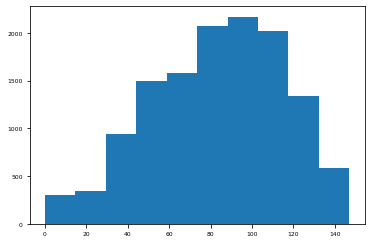

In [24]:
plt.hist(df_interintra['DTW_15_5_Zone'])

In [25]:
li_dist = ['chi2distance', 'DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone','DTW_15_all']
li_info = ['level','level+1','henID1','henID2', 'DOA','weeks_in_laying_barn']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
df_interintra.groupby(['level','is_same_group'])['level+1'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,is_same_group,level+1
0,2020-09-30,False,131
1,2020-09-30,True,131
2,2020-10-01,False,132
3,2020-10-01,True,132
4,2020-10-02,False,132
...,...,...,...
99,2020-11-20,True,131
100,2020-11-21,False,131
101,2020-11-21,True,131
102,2020-11-22,False,131


# Visualise the intra of both group

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


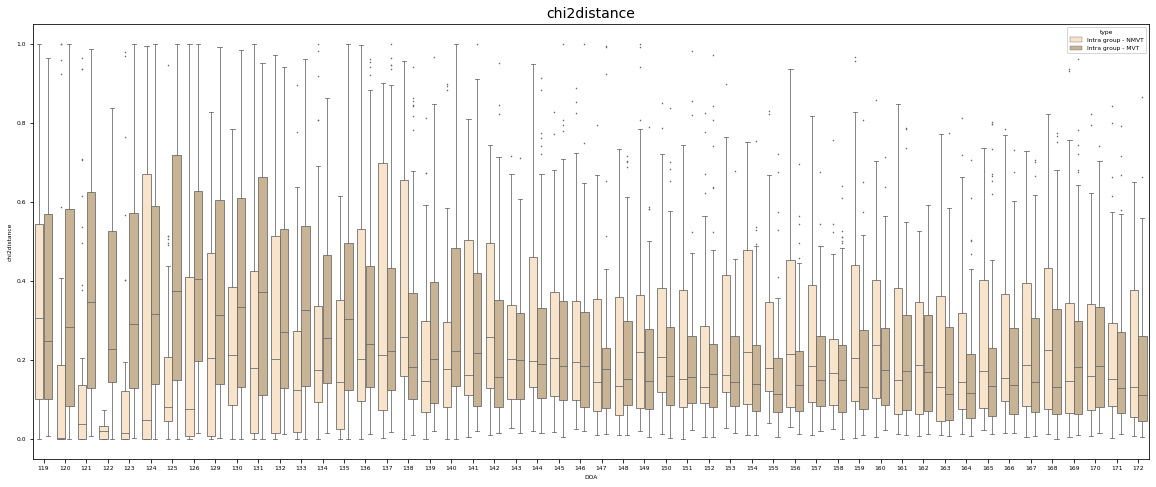

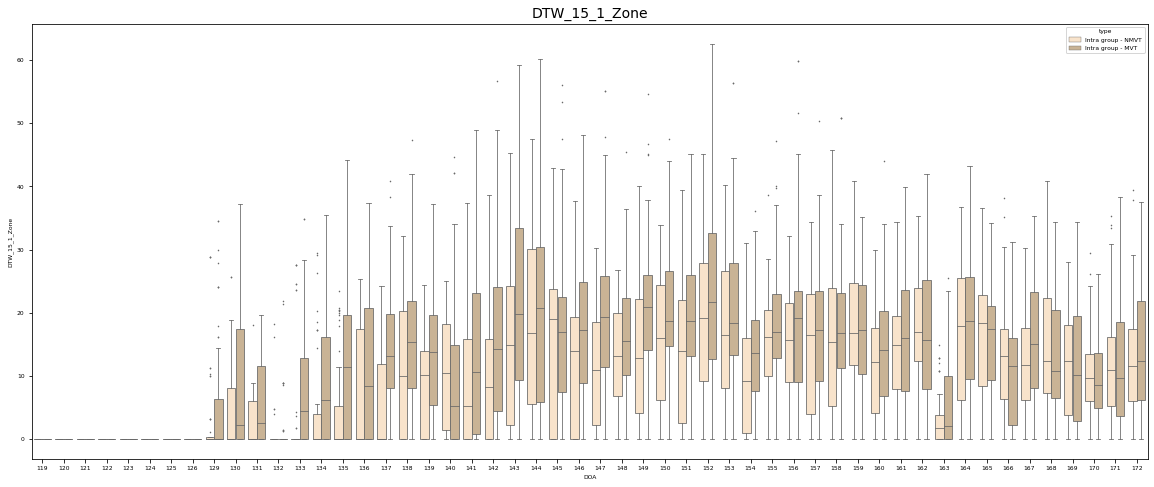

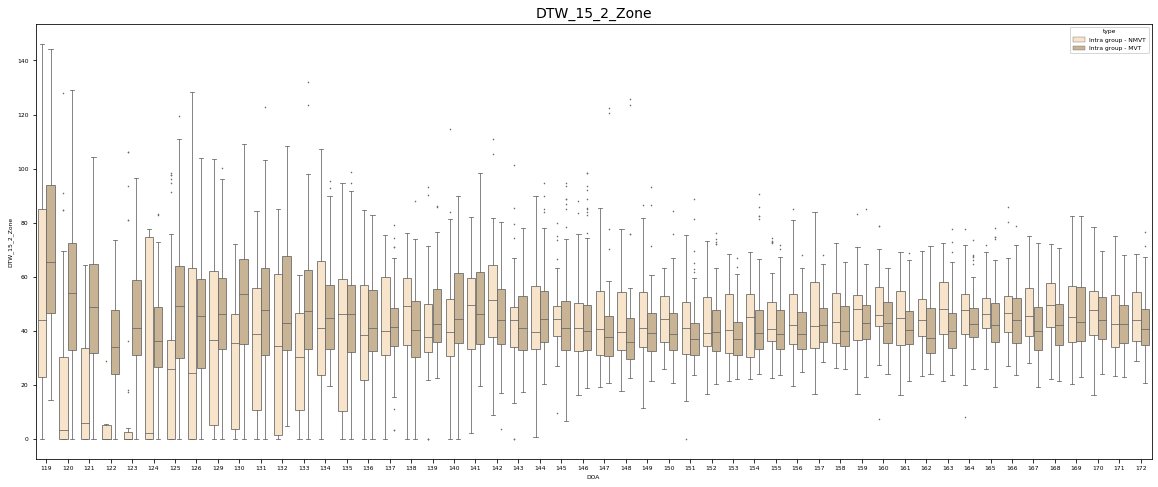

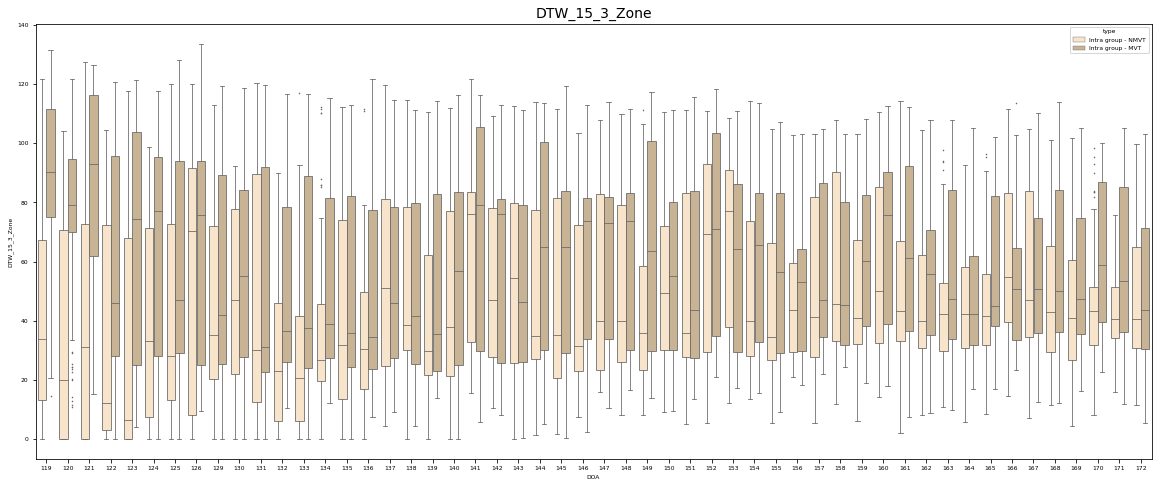

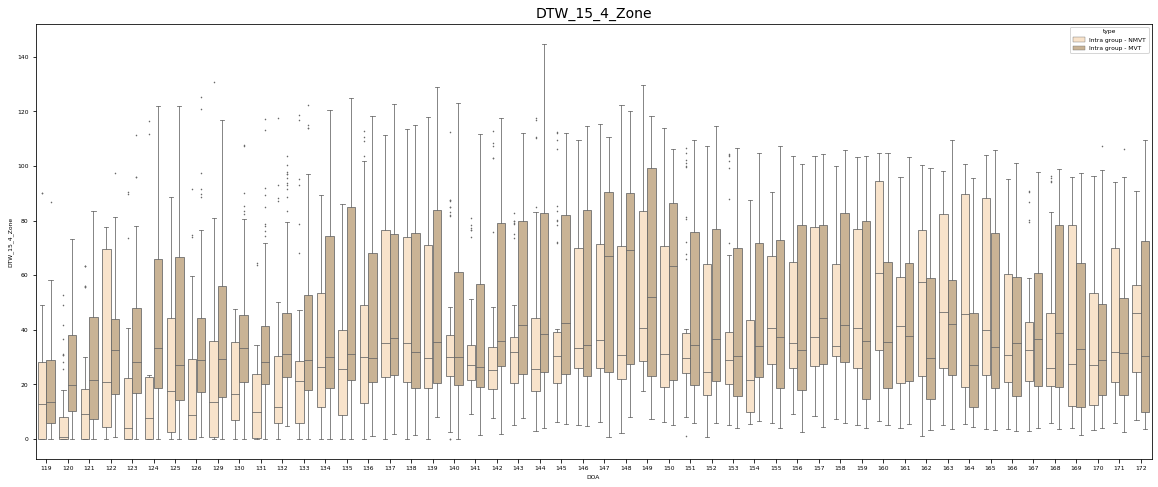

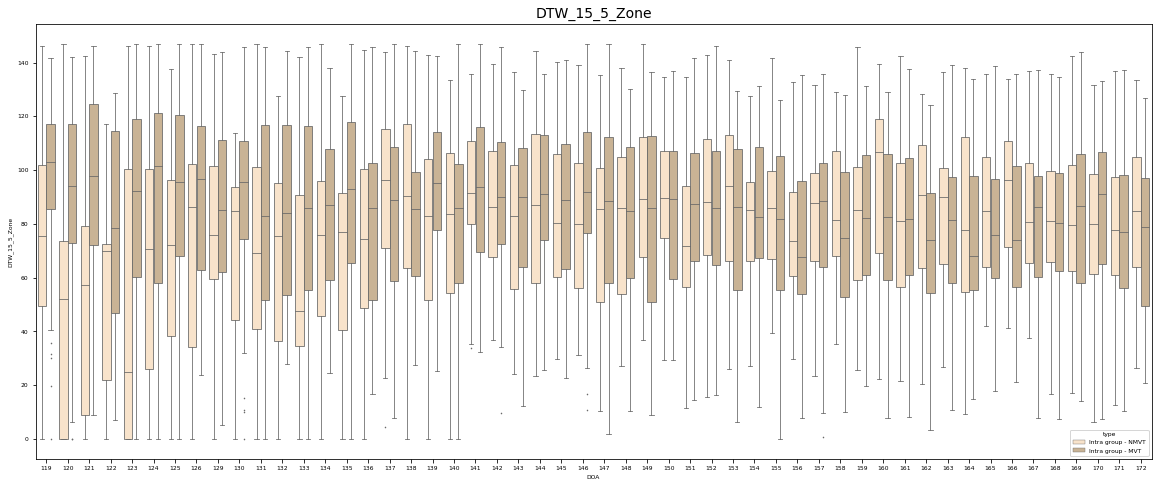

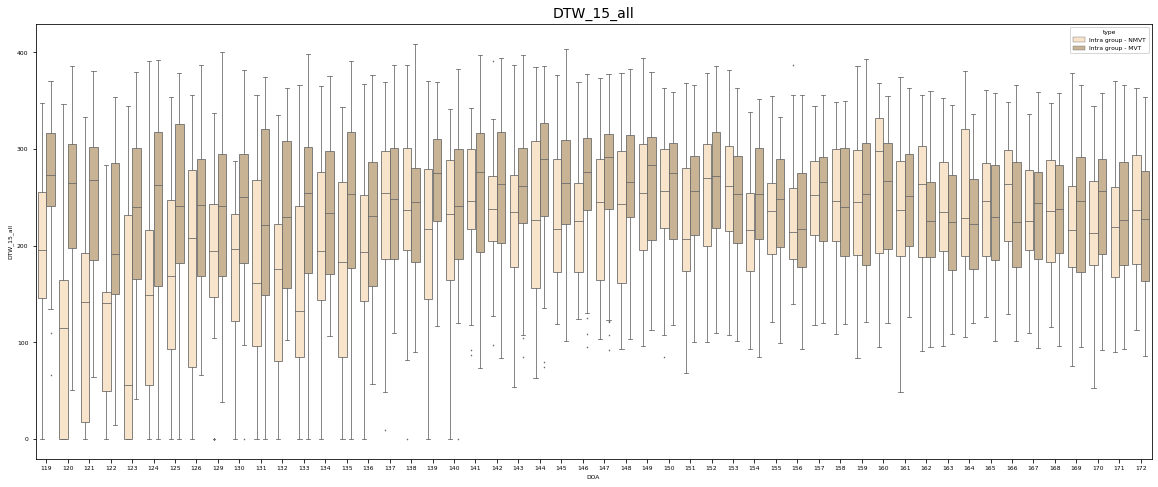

In [27]:
#dont compare the variability as not same amount of hens in each boxplot. But you can comapre the mean
for v in li_dist:
    fig = plt.subplots(figsize=(20,8)) 
    hue_order = ['Intra group - NMVT', 'Intra group - MVT']
    sns.boxplot(x="DOA", y=v, hue="type", data=df_interintra[df_interintra['is_same_group']], 
                linewidth=0.8, fliersize=0.7, palette = {'Intra group - NMVT':'bisque', 'Intra group - MVT':'tan'}, 
                hue_order=hue_order);
    plt.title(v, fontsize=14)
    plt.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'INTRA_'+v+'_DOA.png'),
                dpi=300,format='png',bbox_inches='tight')

# Visualise inter & intra difference & variability

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


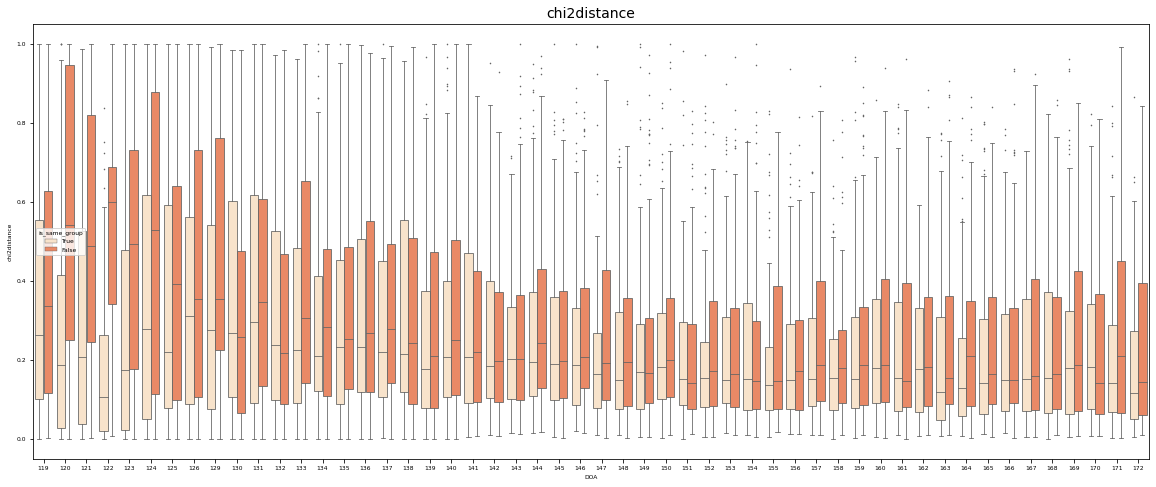

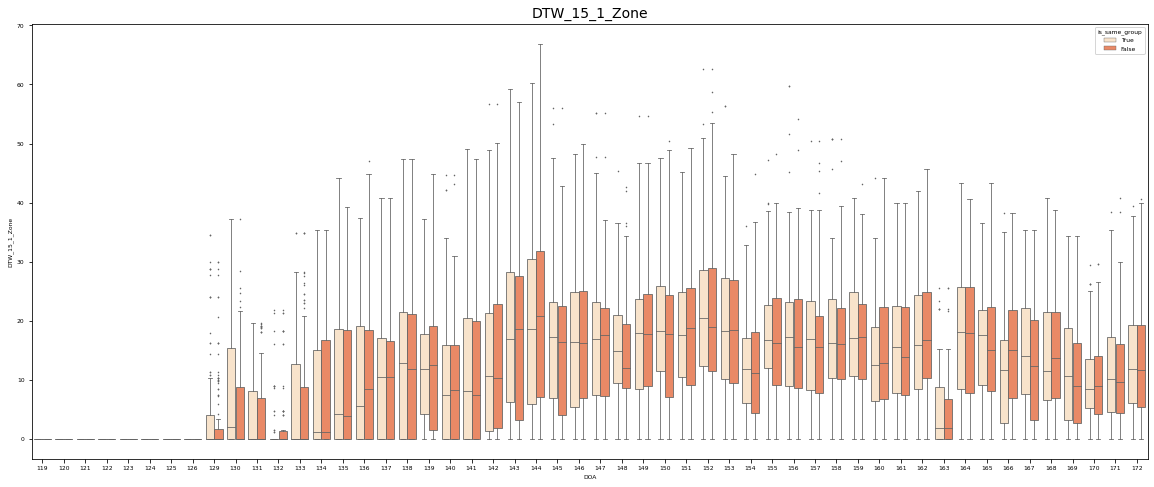

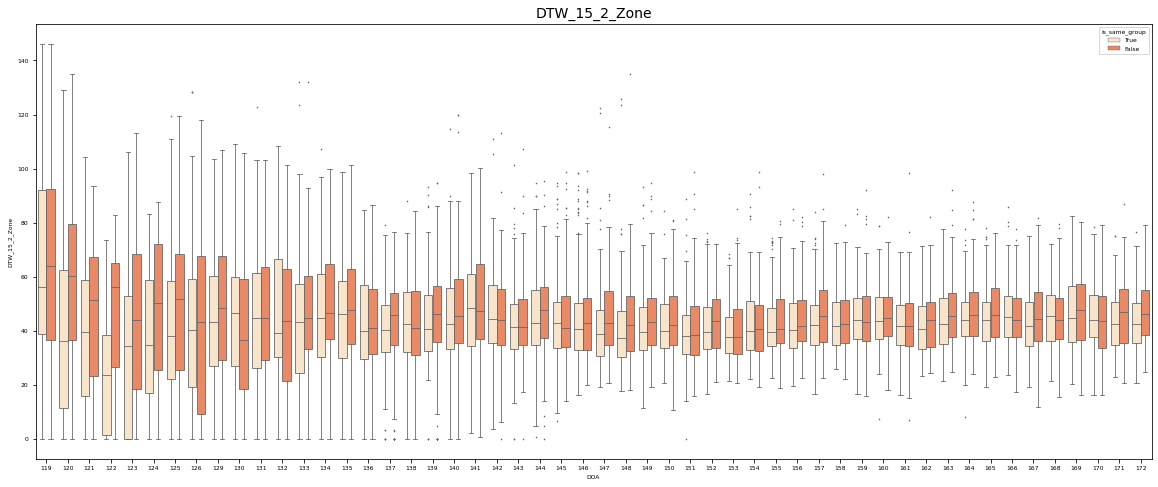

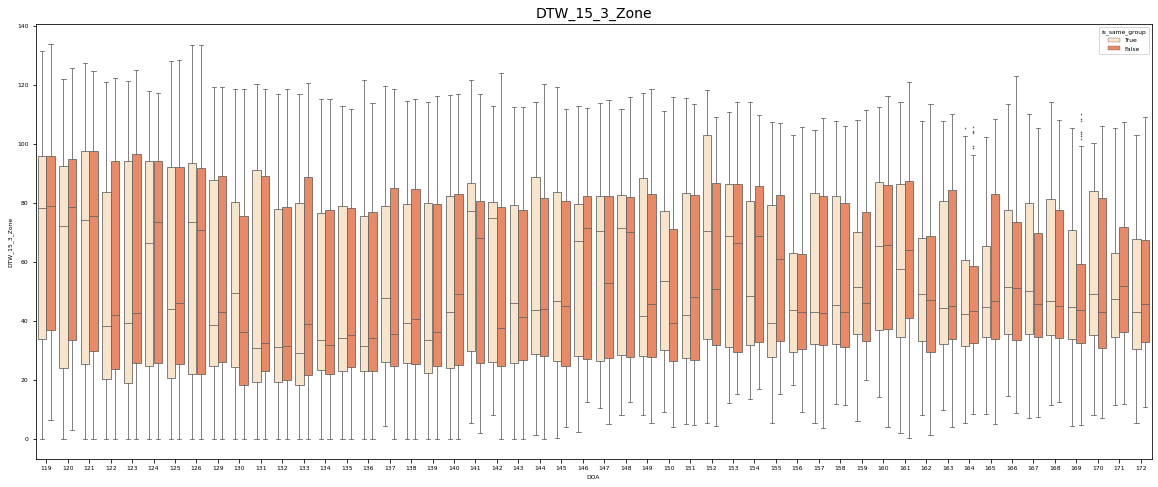

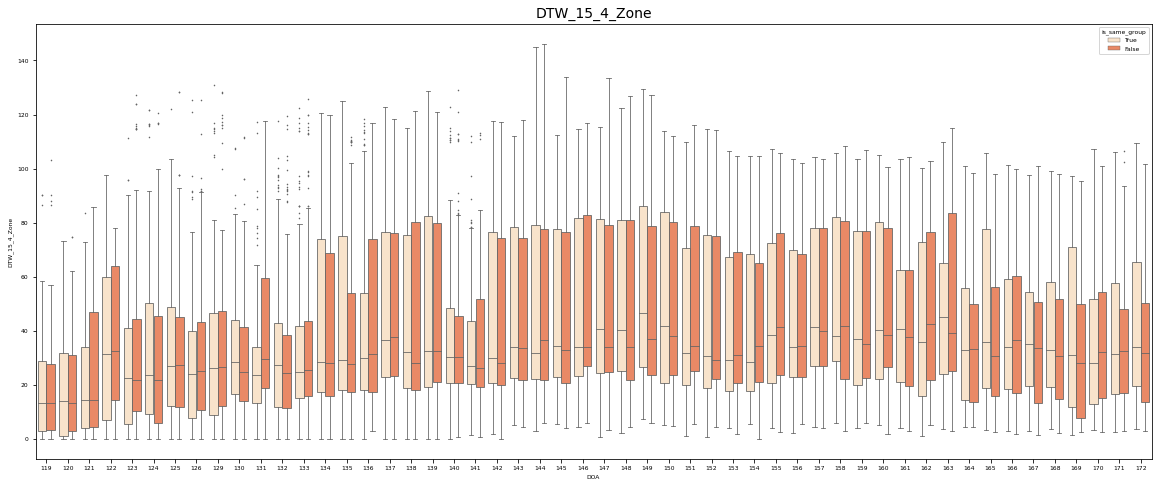

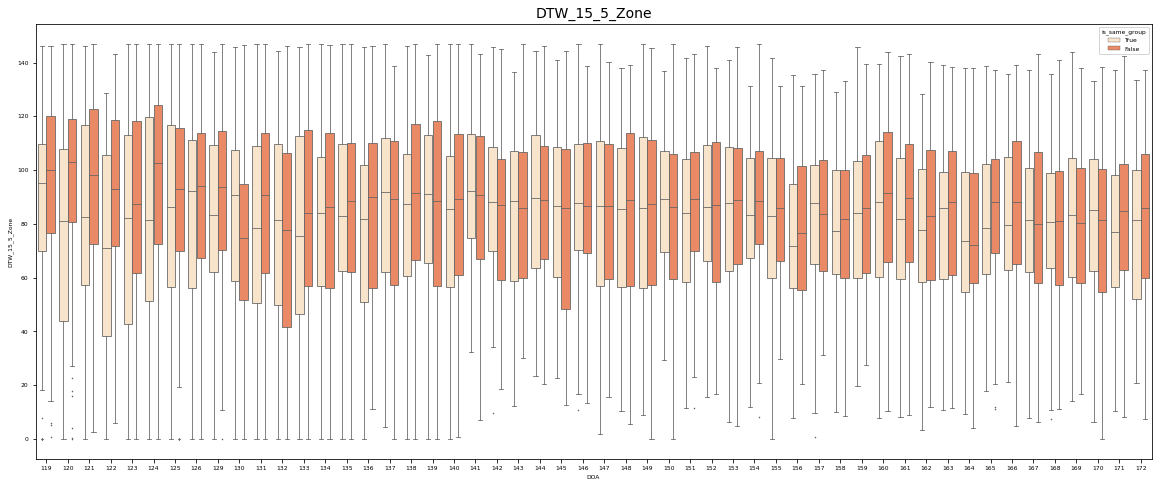

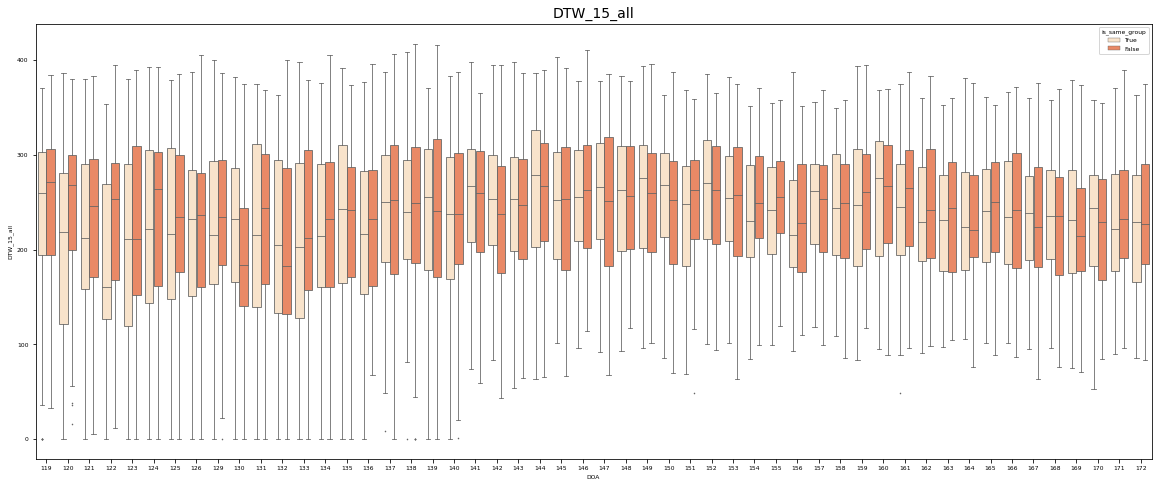

In [28]:
for v in li_dist:
    fig = plt.subplots(figsize=(20,8)) 
    hue_order = [True, False]
    sns.boxplot(x="DOA", y=v, hue="is_same_group", data=df_interintra, 
                linewidth=0.8, fliersize=0.7, palette = {True:'bisque', False:'coral'}, hue_order=hue_order);
    plt.title(v, fontsize=14)
    plt.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'INTRERINTRA_'+v+'_DOA.png'),
                dpi=300,format='png',bbox_inches='tight')

# ANCOVA

# Groups of individuals consistenly more similar?

df_interintra_all['pair'] = df_interintra_all.apply(lambda x: '-'.join(sorted([x['henID1'], x['henID2']])), axis=1)
df_interintra_all['pair'].value_counts()

df_phenop = df_interintra_all[df_interintra_all['DOA']>119+30].groupby(['pair','is_same_ind'])['DTW_15_all'].agg(lambda x: list(x)).reset_index()
df_phenop['var'] = df_phenop['DTW_15_all'].map(lambda x: np.var(x))
df_phenop['avg'] = df_phenop['DTW_15_all'].map(lambda x: np.mean(x))
df_phenop['nbr_obs'] = df_phenop['DTW_15_all'].map(lambda x: len(x))
print(df_phenop.shape)
df_phenop.head(3)

sns.histplot(df_phenop, x="var", hue="is_same_ind", element="step", stat="density", common_norm=False)
plt.show()
sns.histplot(df_phenop, x="avg", hue="is_same_ind", element="step", stat="density", common_norm=False);

df_phenop['similar_birds'] = df_phenop.apply(lambda x: (x['var']<3000)&(x['avg']<180), axis=1)
df_phenop['similar_birds'].value_counts()

#keeping the intra difference allows to verify fo rthe technique as well :)
df_phenop[(df_phenop['similar_birds'])&(~df_phenop['is_same_ind'])].head(80)

### Basic hen ts visual

li_hens = list(set([i.split('-')[0] for i in df_phenop[(df_phenop['similar_birds'])&(~df_phenop['is_same_ind'])]['pair'].tolist()]+\
[i.split('-')[1] for i in df_phenop[(df_phenop['similar_birds'])&(~df_phenop['is_same_ind'])]['pair'].tolist()]))
print(len(li_hens))
rv = str(uuid.uuid1())
print(rv)
dico_ = {h:rv for h in li_hens}

#choose specific dates to plot, November is better as hens starts to move more and the algo have never seen it
dmin = dt.datetime(2020,10,30)
dmax = dt.datetime(2020,11,23)
#define the cluster dic
ts_visual(df_=df, dmin=dmin, dmax=dmax, dico_h_cl=dico_, path_=path_extracted_data_visual_adap_MVTCLUSTER_tsvisual)